In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import numpy as np
from scipy.stats import zscore
from scipy.stats import pearsonr

# KBQ1
Which Local Government Areas (LGAs) have the highest proportions of children developmentally vulnerable in two or more domains (DV2), and how do these areas compare in terms of socio-economic disadvantage (SEIFA), remoteness, and population size?

## load data

In [5]:
# AEDC dataset
df_T7 = pd.read_excel("LGASPLIT/LGA-7-Two or more.xlsx")
df_T7_state = pd.read_excel("LGASPLIT/LGA-7-state.xlsx")
df_T8 = pd.read_excel("LGASPLIT/LGA-8-On track all.xlsx")
df_T8_state = pd.read_excel("LGASPLIT/LGA-8-state.xlsx")

In [6]:
# Preschool Education dataset
df_p6 = pd.read_excel("424/table6.xlsx")
df_p12 = pd.read_excel("424/table12.xlsx")
df_p16 = pd.read_excel("424/table16.xlsx")

In [7]:
# Australian postcode
postcode_df = pd.read_csv("australian_postcodes.csv")

In [8]:
# SEIFA index dataset
df_s2 = pd.read_excel("Local Government Area, Indexes, SEIFA 2021/table2.xlsx")

## visualization

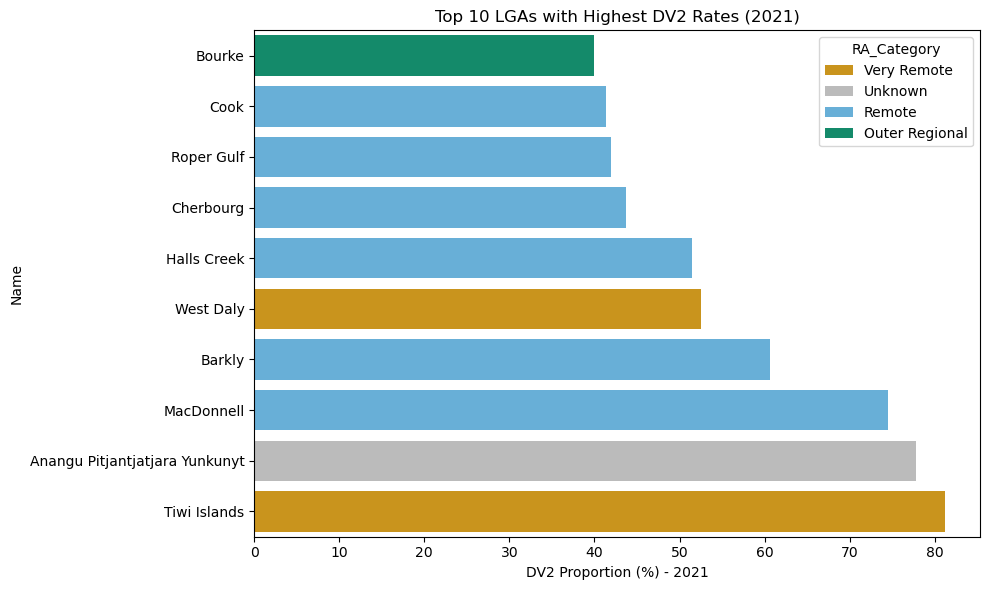

In [10]:
df_T7["% for 2021"] = pd.to_numeric(df_T7["% for 2021"], errors='coerce')

top10_dv2_user_var = df_T7[["Name", "% for 2021",'Code']].sort_values(by="% for 2021", ascending=False).head(10).copy()

manual_ra_dict = {
    'Tiwi Islands': 'Very Remote',
    'Anangu Pitjantjatjara Yankunyt': 'Very Remote',
    'MacDonnell': 'Remote',
    'Barkly': 'Remote',
    'West Daly': 'Very Remote',
    'Halls Creek': 'Remote',
    'Cherbourg': 'Remote',
    'Roper Gulf': 'Remote',
    'Cook': 'Remote',
    'Bourke': 'Outer Regional'
}

top10_dv2_user_var["RA_Category"] = top10_dv2_user_var["Name"].map(manual_ra_dict).fillna("Unknown")

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10_dv2_user_var,
    y="Name",
    x="% for 2021",
    hue="RA_Category",
    dodge=False,
    palette={
        "Very Remote": "#E69F00",
        "Remote": "#56B4E9",
        "Outer Regional": "#009E73",
        "Unknown": "#BBBBBB"
    }
)

plt.xlabel("DV2 Proportion (%) - 2021")
plt.title("Top 10 LGAs with Highest DV2 Rates (2021)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [11]:

top10_dv2_user_var["Code"] = top10_dv2_user_var["Code"].astype(int)
df_s2["2021 Local Government Area (LGA) Code"] = df_s2["2021 Local Government Area (LGA) Code"].astype(int)

top10_with_seifa = pd.merge(
    top10_dv2_user_var,
    df_s2[["2021 Local Government Area (LGA) Code", "2021 Local Government Area (LGA) Name", "Score", "AU Decile"]],
    left_on="Code",
    right_on="2021 Local Government Area (LGA) Code",
    how="left"
)

top10_with_seifa["Is Disadvantaged (Decile 1-3)"] = top10_with_seifa["AU Decile"] <= 3

pd.set_option("display.max_columns", None)
top10_with_seifa[["Name", "% for 2021", "AU Decile", "Is Disadvantaged (Decile 1-3)"]]

,Name,% for 2021,AU Decile,Is Disadvantaged (Decile 1-3)
0,Tiwi Islands,81.250000,1,True
1,Anangu Pitjantjatjara Yunkunyt,77.777778,1,True
2,MacDonnell,74.545455,1,True
3,Barkly,60.606061,1,True
4,West Daly,52.542373,1,True
5,Halls Creek,51.428571,1,True
6,Cherbourg,43.750000,1,True
7,Roper Gulf,41.935484,1,True
8,Cook,41.333333,2,True
9,Bourke,40.000000,3,True


In [12]:
df_T7 = df_T7[df_T7["Code"].notna()] 
df_T7.loc[:, "Code"] = df_T7["Code"].astype(int)
postcode_df = postcode_df[postcode_df["lgacode"].notna()]
postcode_df.loc[:, "lgacode"] = postcode_df["lgacode"].astype(int)

lga_state_map = postcode_df[["lgacode", "state"]].drop_duplicates()

df_T7 = df_T7.drop(columns=[col for col in ["lgacode", "state"] if col in df_T7.columns])

df_T7 = pd.merge(df_T7, lga_state_map, left_on="Code", right_on="lgacode", how="left")
df_T7 = df_T7.drop(columns=["lgacode"])

valid_states = ['NSW', 'VIC', 'QLD', 'SA', 'WA', 'TAS', 'NT', 'ACT']
df_T7["state"] = df_T7["state"].str.strip().str.upper()
df_T7 = df_T7[df_T7["state"].isin(valid_states)]

df_T7["% for 2021"] = pd.to_numeric(df_T7["% for 2021"], errors="coerce")
state_dv2_avg = df_T7.groupby("state")["% for 2021"].mean().reset_index()
state_dv2_avg.rename(columns={"% for 2021": "Average DV2 (%)"}, inplace=True)

state_replace = {
    "Vic.": "VIC",
    "Qld": "QLD",
    "Tas.": "TAS",
    "NSW": "NSW",
    "SA": "SA",
    "WA": "WA",
    "NT": "NT",
    "ACT": "ACT"
}
df_p6["state"] = df_p6["state"].replace(state_replace).str.strip().str.upper()

df_p6["Quintile 1"] = pd.to_numeric(df_p6["Quintile 1"], errors="coerce")
df_p6["Total"] = pd.to_numeric(df_p6["Total"], errors="coerce")
df_p6_unique = df_p6.groupby("state")[["Quintile 1", "Total"]].sum().reset_index()
df_p6_unique["Quintile 1 %"] = df_p6_unique["Quintile 1"] / df_p6_unique["Total"] * 100

df_state_merged = pd.merge(state_dv2_avg, df_p6_unique, on="state", how="left")
df_state_merged = df_state_merged.dropna(subset=["Quintile 1 %", "Average DV2 (%)"])


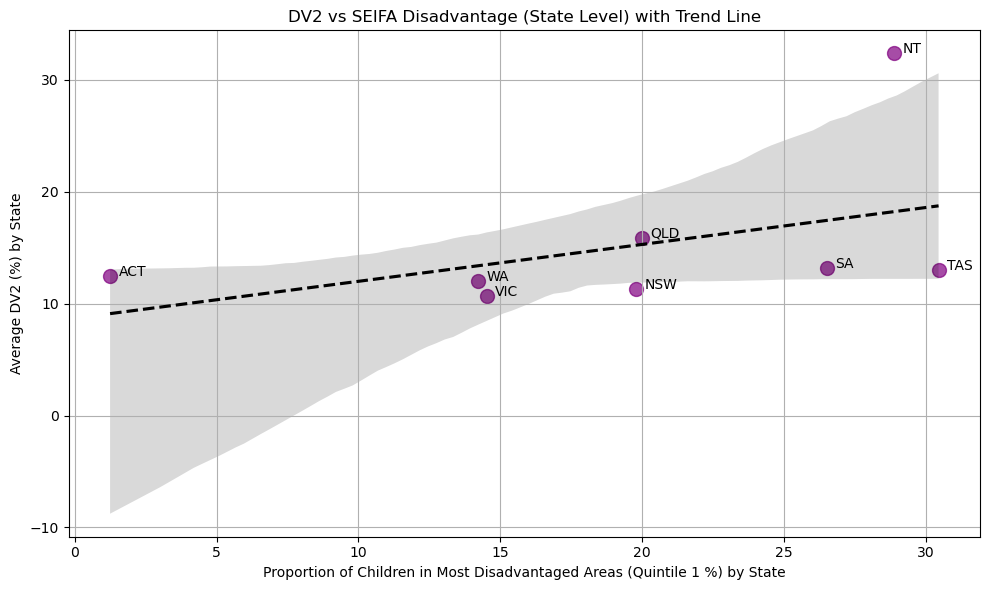

In [13]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df_state_merged,
    x="Quintile 1 %",
    y="Average DV2 (%)",
    scatter_kws={'s': 100, 'color': 'purple', 'alpha': 0.7},
    line_kws={'color': 'black', 'linestyle': '--'}
)

for i in range(len(df_state_merged)):
    plt.text(df_state_merged["Quintile 1 %"].iloc[i] + 0.3,
             df_state_merged["Average DV2 (%)"].iloc[i],
             df_state_merged["state"].iloc[i],
             fontsize=10)

plt.xlabel("Proportion of Children in Most Disadvantaged Areas (Quintile 1 %) by State")
plt.ylabel("Average DV2 (%) by State")
plt.title("DV2 vs SEIFA Disadvantage (State Level) with Trend Line")
plt.grid(True)
plt.tight_layout()
plt.show()

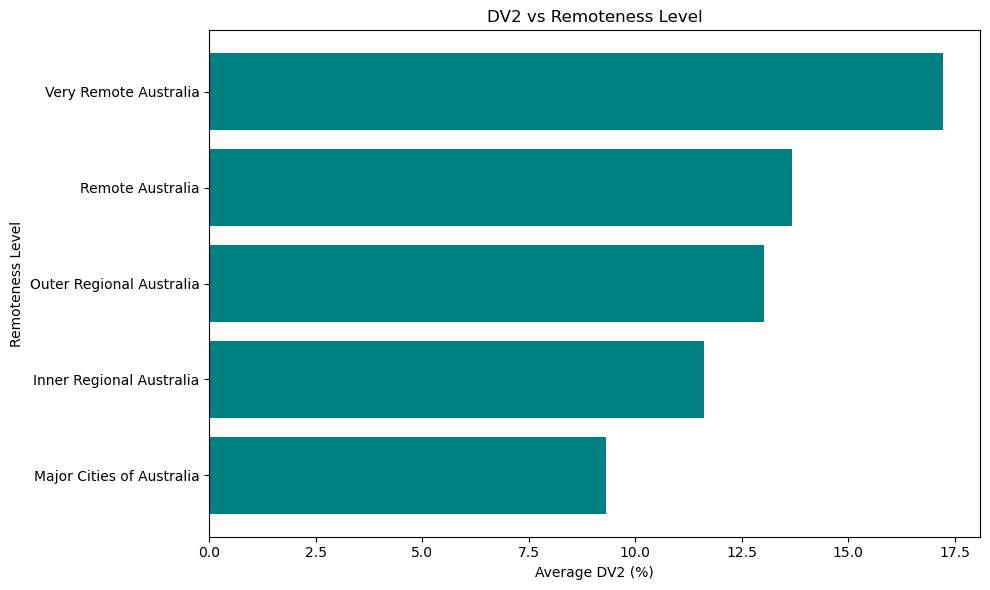

In [14]:
df_T7 = df_T7[df_T7["Code"].notna()]
df_T7["Code"] = df_T7["Code"].astype(int)

postcode_remoteness = postcode_df[["lgacode", "RA_2021_NAME"]].dropna().drop_duplicates()
postcode_remoteness["lgacode"] = postcode_remoteness["lgacode"].astype(int)

df_T7_remoteness = pd.merge(df_T7, postcode_remoteness, left_on="Code", right_on="lgacode", how="left")

df_T7_remoteness = df_T7_remoteness.dropna(subset=["RA_2021_NAME"])
df_T7_remoteness["% for 2021"] = pd.to_numeric(df_T7_remoteness["% for 2021"], errors="coerce")

remoteness_avg = df_T7_remoteness.groupby("RA_2021_NAME")["% for 2021"].mean().reset_index()
remoteness_avg.rename(columns={"% for 2021": "Average DV2 (%)"}, inplace=True)

ra_order = [
    "Major Cities of Australia",
    "Inner Regional Australia",
    "Outer Regional Australia",
    "Remote Australia",
    "Very Remote Australia"
]
remoteness_avg["RA_2021_NAME"] = pd.Categorical(remoteness_avg["RA_2021_NAME"], categories=ra_order, ordered=True)
remoteness_avg = remoteness_avg.sort_values("RA_2021_NAME")

plt.figure(figsize=(10, 6))
plt.barh(remoteness_avg["RA_2021_NAME"], remoteness_avg["Average DV2 (%)"], color="teal")
plt.xlabel("Average DV2 (%)")
plt.ylabel("Remoteness Level")
plt.title("DV2 vs Remoteness Level")
plt.tight_layout()
plt.show()

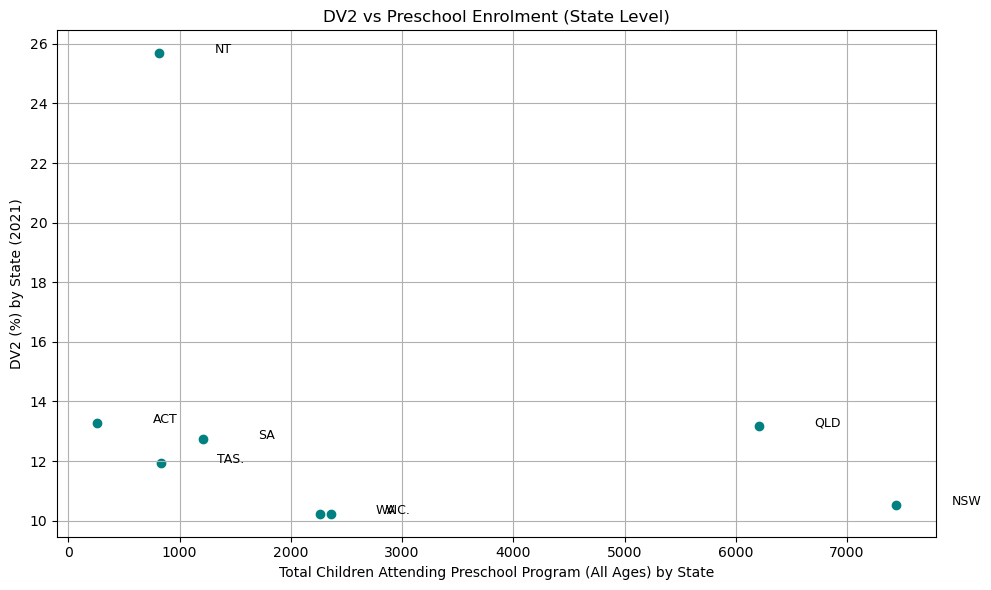

In [15]:
state_map = {
    "New South Wales": "NSW",
    "Victoria": "Vic.",
    "Queensland": "Qld",
    "South Australia": "SA",
    "Western Australia": "WA",
    "Tasmania": "Tas.",
    "Northern Territory": "NT",
    "Australian Capital Territory": "ACT"
}

df_T7_state["state"] = df_T7_state["state"].map(state_map)

df_T7_state.columns = df_T7_state.columns.str.strip()
df_T7_state["state"] = df_T7_state["state"].str.strip().str.upper()
df_T7_state = df_T7_state[["state", "% for 2021"]].rename(columns={"% for 2021": "DV2 (%)"})

df_p12.columns = df_p12.columns.str.strip()
df_p12["state"] = df_p12["state"].str.strip().str.upper()

df_p12["Total children attending a preschool program"] = pd.to_numeric(
    df_p12["Total children attending a preschool program"], errors="coerce"
)
df_enrolment = df_p12.groupby("state", as_index=False)["Total children attending a preschool program"].sum()

df_state_final = pd.merge(df_T7_state, df_enrolment, on="state", how="inner")
df_state_final = df_state_final.dropna(subset=["DV2 (%)", "Total children attending a preschool program"])


plt.figure(figsize=(10, 6))
plt.scatter(df_state_final["Total children attending a preschool program"], df_state_final["DV2 (%)"], color='teal')

for i in range(len(df_state_final)):
    plt.text(df_state_final["Total children attending a preschool program"][i] + 500,
             df_state_final["DV2 (%)"][i],
             df_state_final["state"][i],
             fontsize=9)

plt.xlabel("Total Children Attending Preschool Program (All Ages) by State")
plt.ylabel("DV2 (%) by State (2021)")
plt.title("DV2 vs Preschool Enrolment (State Level)")
plt.grid(True)
plt.tight_layout()
plt.show()

# KBQ2

## load data

In [18]:
# AEDC dataset
df_health = pd.read_excel("LGASPLIT/LGA-1-Health.xlsx")
df_social = pd.read_excel("LGASPLIT/LGA-2-Social.xlsx")
df_emotional = pd.read_excel("LGASPLIT/LGA-3-Emotional.xlsx")
df_language = pd.read_excel("LGASPLIT/LGA-4-Language.xlsx")
df_communication = pd.read_excel("LGASPLIT/LGA-5-Communication.xlsx")

In [19]:
# AEDC dataset
df_p1_state = pd.read_excel("LGASPLIT/LGA-1-state.xlsx")
df_p2_state = pd.read_excel("LGASPLIT/LGA-2-state.xlsx")
df_p3_state = pd.read_excel("LGASPLIT/LGA-3-state.xlsx")
df_p4_state = pd.read_excel("LGASPLIT/LGA-4-state.xlsx")
df_p5_state = pd.read_excel("LGASPLIT/LGA-5-state.xlsx")

In [20]:
def extract_v2021_column(df):
    col = [c for c in df.columns if 'v2021' in str(c).lower()]
    return pd.to_numeric(df[col[0]], errors="coerce") if col else None
# state vulnerability table
df_state_vuln = pd.DataFrame()
df_state_vuln["state"] = df_p1_state.iloc[:, 0].astype(str).str.strip().str.upper()
df_state_vuln["Physical (%)"] = extract_v2021_column(df_p1_state)
df_state_vuln["Social (%)"] = extract_v2021_column(df_p2_state)
df_state_vuln["Emotional (%)"] = extract_v2021_column(df_p3_state)
df_state_vuln["Language (%)"] = extract_v2021_column(df_p4_state)
df_state_vuln["Communication (%)"] = extract_v2021_column(df_p5_state)

In [21]:
df_lga_vuln = pd.DataFrame()
df_lga_vuln['LGA Name'] = df_health.iloc[:, 0].astype(str).str.strip()
df_lga_vuln['Physical (%)'] = extract_v2021_column(df_health)
df_lga_vuln['Social (%)'] = extract_v2021_column(df_social)
df_lga_vuln['Emotional (%)'] = extract_v2021_column(df_emotional)
df_lga_vuln['Language (%)'] = extract_v2021_column(df_language)
df_lga_vuln['Communication (%)'] = extract_v2021_column(df_communication)

In [22]:
df_lga_vuln = df_lga_vuln.copy()

df_lga_vuln.rename(columns={"LGA Name": "LGA Code"}, inplace=True)

df_lga_vuln = df_lga_vuln[pd.to_numeric(df_lga_vuln["LGA Code"], errors='coerce').notna()]

df_lga_vuln.loc[:, "LGA Code"] = df_lga_vuln["LGA Code"].astype(float).astype(int)

df_lga_vuln = df_lga_vuln.dropna(subset=[
    "Physical (%)", "Social (%)", "Emotional (%)", "Language (%)", "Communication (%)"
], how='all')


In [23]:
df_merged = pd.merge(
    df_s2,
    df_lga_vuln,
    left_on='2021 Local Government Area (LGA) Code',
    right_on='LGA Code',
    how='inner'
)
df_merged.head()

,2021 Local Government Area (LGA) Code,2021 Local Government Area (LGA) Name,Usual Resident Population,Score,AU Rank,AU Decile,AU Percentile,State,STATE Rank,STATE Decile,STATE Percentile,Minimum score for SA1s in area,Maximum score for SA1s in area,% Usual Resident Population without an SA1 level score,LGA Code,Physical (%),Social (%),Emotional (%),Language (%),Communication (%)
0,10050,Albury,56093,967.904028,232,5,43,NSW,51.0,4.0,40.0,535.483456,1126.279453,0.000499,10050,74.0,NaN,NaN,NaN,NaN
1,10180,Armidale Regional,29124,980.361546,281,6,52,NSW,66.0,6.0,51.0,485.067025,1113.666315,0.031795,10180,38.0,80.0,64.0,41.0,63.0
2,10250,Ballina,46296,1015.142657,411,8,76,NSW,98.0,8.0,76.0,406.156284,1132.771918,0.000281,10250,28.0,32.0,30.0,31.0,32.0
3,10300,Balranald,2208,960.162516,200,4,37,NSW,40.0,4.0,31.0,869.826495,1079.040279,0.000000,10300,6.0,28.0,35.0,27.0,25.0
4,10470,Bathurst Regional,43567,991.494086,330,7,61,NSW,83.0,7.0,64.0,604.106821,1150.157153,0.025937,10470,82.0,3.0,3.0,2.0,3.0


In [24]:
# Preschool Education dataset
df_p9 = pd.read_excel("424/table9.xlsx")
df_p10 = pd.read_excel("424/table10.xlsx")
df_p16 = pd.read_excel("424/table16.xlsx")
df_p17 = pd.read_excel("424/table17.xlsx")
df_p32 = pd.read_excel("424/table32.xlsx")

In [25]:
# Education Services Dataset
df_score = pd.read_csv("Education-services-au-export.csv")

/var/folders/34/8qk_pvgs6k516pnk4q06n2200000gn/T/ipykernel_43123/2086943961.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_score = pd.read_csv("Education-services-au-export.csv")


In [26]:
df_score_lga = df_score[[
    'ServiceApprovalNumber',     
    'ServiceName',              
    'ServiceAddress',           
    'Suburb',                  
    'State',                   
    'Postcode',                
    'OverallRating'           
]]

In [27]:
rating_map = {
    'Significant Improvement Required': 0,
    'Working Towards NQS': 1,
    'Meeting NQS': 2,
    'Exceeding NQS': 3,
    'Excellent':4,
    'Provisional – Not Yet Assessed': None 
}
df_score_lga = df_score_lga.copy()  

df_score_lga.loc[:, "rating_score"] = df_score_lga["OverallRating"].map(rating_map)

In [28]:
# RA LEVEL IN 2021
df_RA = pd.read_excel('RA_2021_AUST.xlsx')

## visualization

In [30]:
df_p6.columns = df_p6.columns.str.strip()
df_p6["state"] = df_p6["state"].str.strip().str.upper()
df_p6["Quintile 1"] = pd.to_numeric(df_p6["Quintile 1"], errors="coerce")
df_p6["Total"] = pd.to_numeric(df_p6["Total"], errors="coerce")
df_p6["Quintile 1 %"] = df_p6["Quintile 1"] / df_p6["Total"] * 100

state_seifa = df_p6.groupby("state", as_index=False)["Quintile 1 %"].mean()

df_state_vuln["state"] = df_state_vuln["state"].str.strip().str.upper()

state_map = {
    "NEW SOUTH WALES": "NSW",
    "VICTORIA": "VIC.",
    "QUEENSLAND": "QLD",
    "SOUTH AUSTRALIA": "SA",
    "WESTERN AUSTRALIA": "WA",
    "TASMANIA": "TAS.",
    "NORTHERN TERRITORY": "NT",
    "AUSTRALIAN CAPITAL TERRITORY": "ACT"
}

df_state_vuln["state"] = df_state_vuln["state"].map(state_map)

df_state_final = pd.merge(df_state_vuln, state_seifa, on="state", how="left")

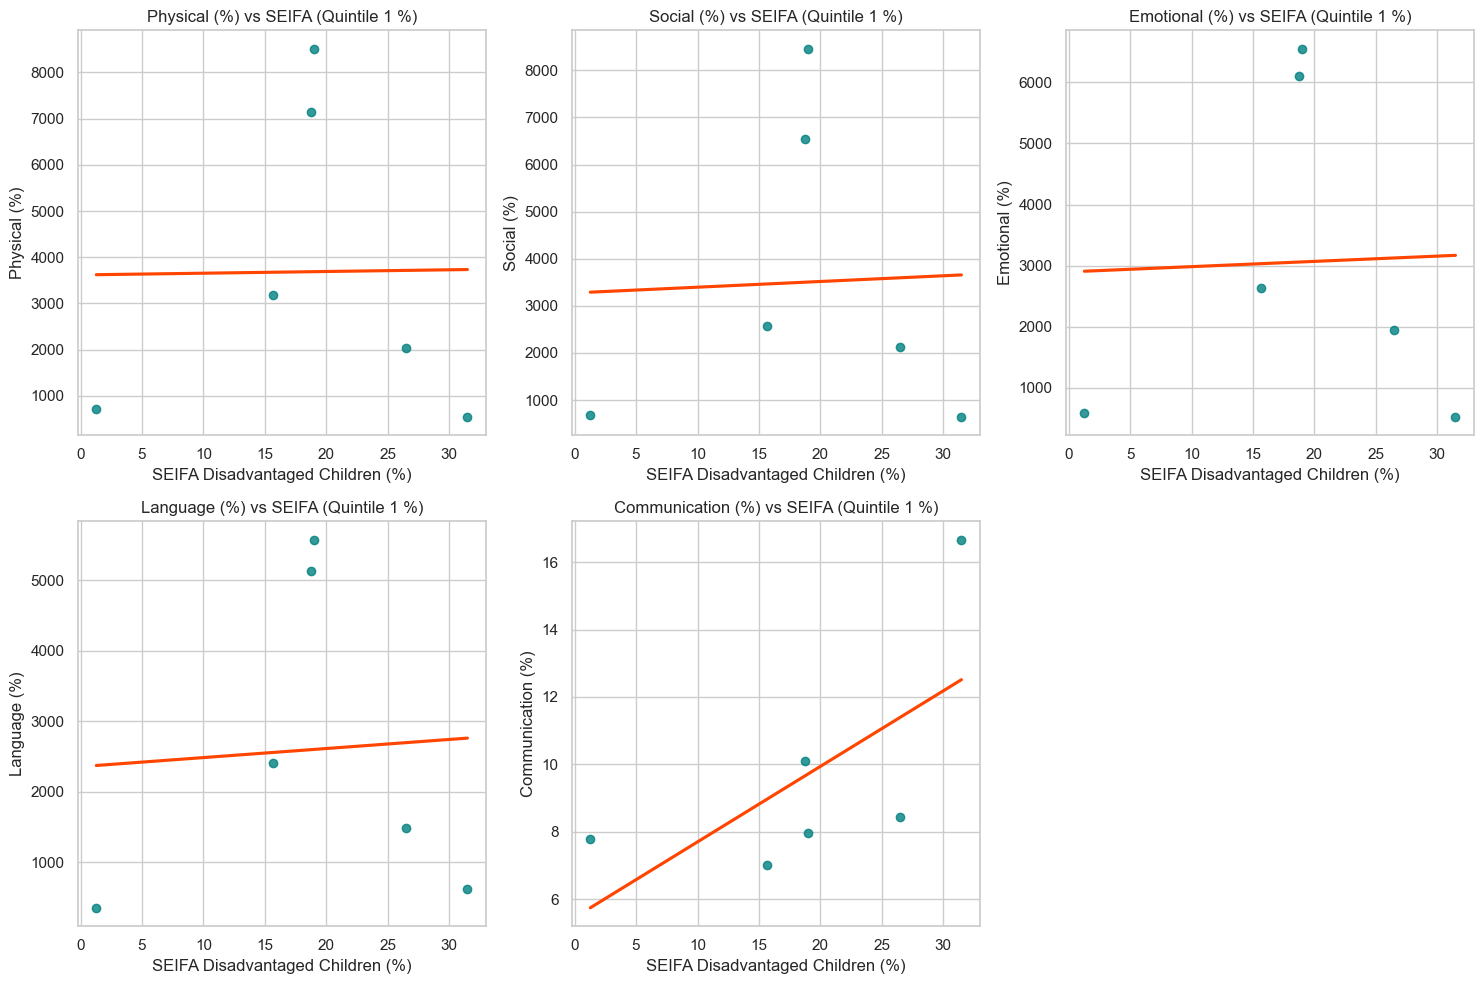

In [31]:
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")

domains = ["Physical (%)", "Social (%)", "Emotional (%)", "Language (%)", "Communication (%)"]

for idx, domain in enumerate(domains, 1):
    plt.subplot(2, 3, idx)
    sns.regplot(
        data=df_state_final,
        x="Quintile 1 %",
        y=domain,
        ci=None,
        scatter_kws={'color': 'teal'},
        line_kws={'color': 'orangered'}
    )
    plt.title(f"{domain} vs SEIFA (Quintile 1 %)")
    plt.xlabel("SEIFA Disadvantaged Children (%)")
    plt.ylabel(domain)
plt.tight_layout()
plt.show()

In [32]:
domains = ["Physical (%)", "Social (%)", "Emotional (%)", "Language (%)", "Communication (%)"]
correlations = df_state_final[domains + ["Quintile 1 %"]].corr(method="pearson")

seifa_corr = correlations["Quintile 1 %"].drop("Quintile 1 %").sort_values(key=abs, ascending=False)

print("Correlation between each domain and SEIFA (Quintile 1 %):")
print(seifa_corr)

Correlation between each domain and SEIFA (Quintile 1 %):
Communication (%)    0.648691
Language (%)         0.059072
Social (%)           0.038686
Emotional (%)        0.033523
Physical (%)         0.011352
Name: Quintile 1 %, dtype: float64


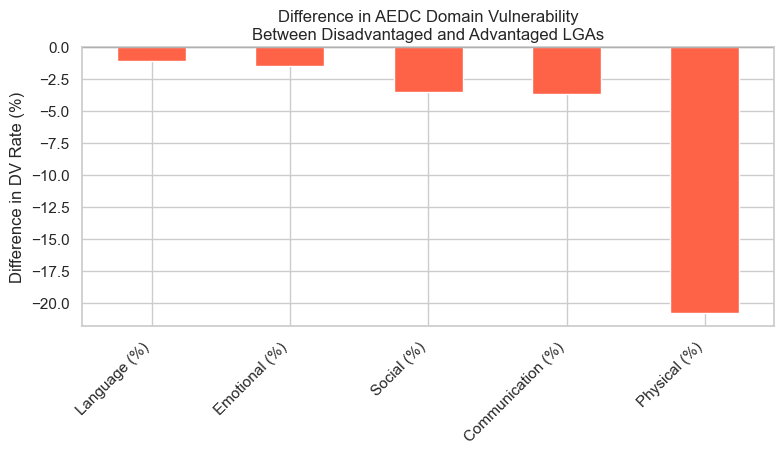

In [33]:
df_merged['Disadvantage Group'] = df_merged['AU Decile'].apply(lambda x: 'Disadvantaged' if x <= 3
                                                 else 'Advantaged' if x >= 8 else 'Mid')


df_comp = df_merged[df_merged["Disadvantage Group"].isin(["Disadvantaged", "Advantaged"])]

domains = ["Physical (%)", "Social (%)", "Emotional (%)", "Language (%)", "Communication (%)"]

group_means = df_comp.groupby("Disadvantage Group")[domains].mean()

diff = group_means.loc["Disadvantaged"] - group_means.loc["Advantaged"]
diff = diff.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
diff.plot(kind='bar', color='tomato')
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel('Difference in DV Rate (%)')
plt.title('Difference in AEDC Domain Vulnerability\nBetween Disadvantaged and Advantaged LGAs')
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

In [34]:
df_score_lga.loc[:, "Postcode"] = pd.to_numeric(df_score_lga["Postcode"], errors="coerce")
postcode_df.loc[:, "postcode"] = pd.to_numeric(postcode_df["postcode"], errors="coerce")

postcode_map = postcode_df[["postcode", "lgacode",'SA1_CODE_2021']].drop_duplicates()

df_score_lga_mapped = pd.merge(df_score_lga, postcode_map, left_on="Postcode", right_on="postcode", how="left")

In [35]:
df_score_lga_mapped["SA1_CODE_2021"] = (
    pd.to_numeric(df_score_lga_mapped["SA1_CODE_2021"], errors="coerce")
    .dropna()
    .astype("int64")
    .astype(str)
)

df_RA["SA1_CODE_2021"] = df_RA["SA1_CODE_2021"].astype(str).str.strip()

df_score_lga_mapped = pd.merge(
    df_score_lga_mapped,
    df_RA[["SA1_CODE_2021", "RA_CODE_2021", "RA_NAME_2021"]],
    on="SA1_CODE_2021",
    how="left"
)

df_score_lga_mapped.head()


,ServiceApprovalNumber,ServiceName,ServiceAddress,Suburb,State,Postcode,OverallRating,rating_score,postcode,lgacode,SA1_CODE_2021,RA_CODE_2021,RA_NAME_2021
0,SE-00000002,Community Kids Waterford Early Education Centre,8-10 Allora St,WATERFORD WEST,QLD,4133.0,Meeting NQS,2.0,4133.0,34590.0,31105132815,30,Major Cities of Australia
1,SE-00000003,KIDVENTURE EARLY LEARNING EAGLEBY,82 Fryar Road,EAGLEBY,QLD,4207.0,Working Towards NQS,1.0,4207.0,33430.0,31105132316,30,Major Cities of Australia
2,SE-00000004,Community Kids - Broadbeach Waters,4 Fremar Street,BROADBEACH WATERS,QLD,4217.0,Meeting NQS,2.0,4217.0,33430.0,30910156227,30,Major Cities of Australia
3,SE-00000005,Little Scholars School of Early Learning Burle...,143 Christine Ave,BURLEIGH WATERS,QLD,4220.0,Meeting NQS,2.0,4220.0,33430.0,30908126219,30,Major Cities of Australia
4,SE-00000006,Small World Child Care Centre,113-115 Pappas Way,CARRARA,QLD,4211.0,Meeting NQS,2.0,4211.0,36510.0,30906124944,30,Major Cities of Australia


In [36]:
ra_order = [
    "Major Cities of Australia",
    "Inner Regional Australia",
    "Outer Regional Australia",
    "Remote Australia",
    "Very Remote Australia"
]
df_ra_avg = df_score_lga_mapped.groupby("RA_NAME_2021")["rating_score"].mean().reindex(ra_order).reset_index()

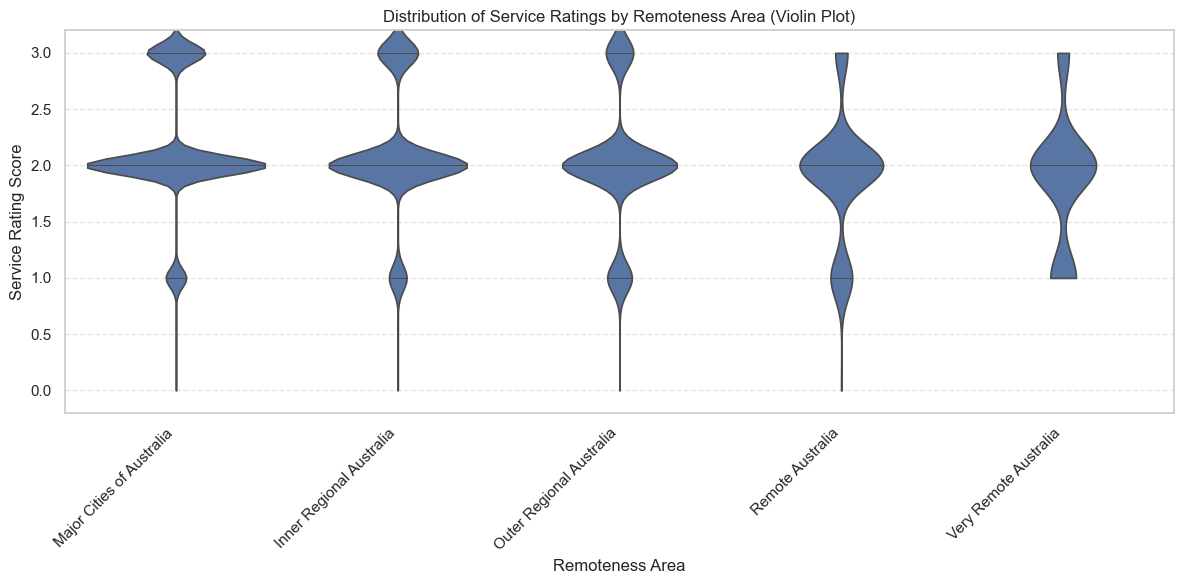

In [37]:
plt.figure(figsize=(12, 6))
sns.violinplot(
    data=df_score_lga_mapped,
    x="RA_NAME_2021",
    y="rating_score",
    order=ra_order,
    cut=0,         
    inner="stick"  
)
plt.xticks(rotation=45, ha="right")
plt.ylim(-0.2, 3.2)
plt.ylabel("Service Rating Score")
plt.xlabel("Remoteness Area")
plt.title("Distribution of Service Ratings by Remoteness Area (Violin Plot)")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("Distribution_of_Service_Ratings_by_Remoteness_Area_Cleaned.png", dpi=300)
plt.show()


In [38]:
df_rating_lga = df_score_lga_mapped.groupby("lgacode").agg(
    avg_rating=("rating_score", "mean"),
    num_services=("rating_score", "count")
).reset_index()

df_rating_lga = df_score_lga_mapped.groupby("lgacode").agg(
    avg_rating=("rating_score", "mean"),
    num_services=("rating_score", "count")
).reset_index()

df_dv2_2021 = df_T7[["Code", "% for 2021"]].copy()
df_dv2_2021.columns = ["lgacode", "dv2_percent"]
df_dv2_2021["lgacode"] = pd.to_numeric(df_dv2_2021["lgacode"], errors="coerce")

df_dv2_2021["dv2_percent"] = (
    df_dv2_2021["dv2_percent"]
    .replace("*", np.nan)                      
    .replace(r"[^\d.]+", "", regex=True)       
)

df_dv2_2021["dv2_percent"] = pd.to_numeric(df_dv2_2021["dv2_percent"], errors="coerce")

df_lga_combined = pd.merge(df_rating_lga, df_dv2_2021, on="lgacode", how="inner")

df_lga_combined["dv2_percent"] = pd.to_numeric(df_lga_combined["dv2_percent"], errors="coerce")

df_state_info = df_score_lga_mapped[["lgacode", "State"]].drop_duplicates()
df_lga_combined = pd.merge(df_lga_combined, df_state_info, on="lgacode", how="left")

In [39]:
df_lga_combined["service_size_group"] = pd.cut(
    df_lga_combined["num_services"],
    bins=[0, 50, 150, 300, 500, float("inf")],
    labels=["1-50", "51-150", "151-300", "301-500", "500+"]
)

In [40]:
df_lga_combined["z_rating"] = zscore(df_lga_combined["avg_rating"])
df_lga_combined["z_dv2"] = zscore(df_lga_combined["dv2_percent"])

outliers = df_lga_combined[(abs(df_lga_combined["z_rating"]) > 3) | (abs(df_lga_combined["z_dv2"]) > 3)]

In [41]:
df_lga_combined["z_rating"] = zscore(df_lga_combined["avg_rating"].dropna())
df_lga_combined["z_rating"] = df_lga_combined["z_rating"].reindex(df_lga_combined.index)

df_lga_combined["z_dv2"] = zscore(df_lga_combined["dv2_percent"].dropna())
df_lga_combined["z_dv2"] = df_lga_combined["z_dv2"].reindex(df_lga_combined.index)

In [42]:
df_lga_filtered = df_lga_combined[(abs(df_lga_combined["z_rating"]) <= 3) & 
                                  (abs(df_lga_combined["z_dv2"]) <= 3)]

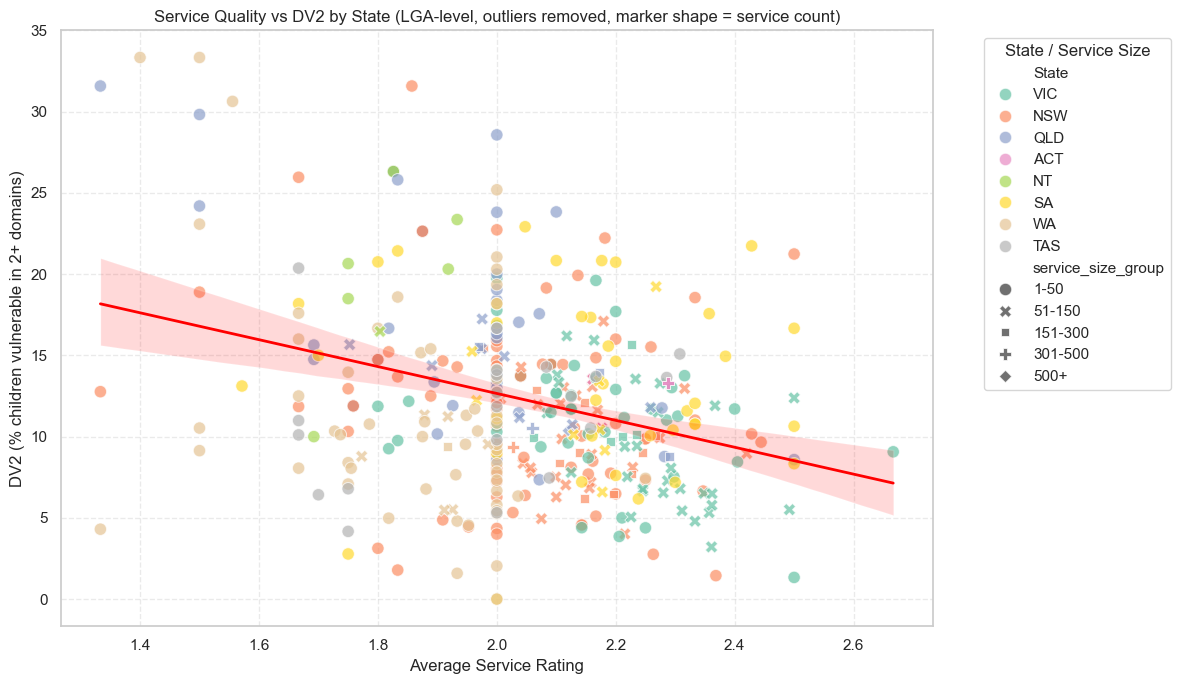

Filtered Pearson correlation between avg rating and DV2: -0.316


In [43]:
plt.figure(figsize=(12, 7))

sns.scatterplot(
    data=df_lga_filtered,
    x="avg_rating",
    y="dv2_percent",
    hue="State",
    style="service_size_group",
    palette="Set2",
    alpha=0.7,
    edgecolor="w",
    s=80
)


sns.regplot(
    data=df_lga_filtered,
    x="avg_rating",
    y="dv2_percent",
    scatter=False,
    line_kws={"color": "red", "lw": 2},
    ci=95
)

plt.xlabel("Average Service Rating")
plt.ylabel("DV2 (% children vulnerable in 2+ domains)")
plt.title("Service Quality vs DV2 by State (LGA-level, outliers removed, marker shape = service count)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="State / Service Size", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("Service Quality vs DV2 by State (LGA-level, outliers removed, marker shape = service count).png", dpi=300)
plt.show()


corr_filtered = df_lga_filtered["avg_rating"].corr(df_lga_filtered["dv2_percent"])
print(f"Filtered Pearson correlation between avg rating and DV2: {corr_filtered:.3f}")

In [44]:
states = df_lga_filtered["State"].unique()
df_lga_filtered = pd.merge(
    df_lga_filtered,
    df_score_lga_mapped[['lgacode', 'RA_NAME_2021']].drop_duplicates(),
    on='lgacode',
    how='left'
)


In [45]:
df_lga_filtered

,lgacode,avg_rating,num_services,dv2_percent,State,service_size_group,z_rating,z_dv2,RA_NAME_2021
0,10050.0,2.040000,25,13.734568,VIC,1-50,0.043374,0.138457,Inner Regional Australia
1,10050.0,2.040000,25,13.734568,NSW,1-50,0.043374,0.138457,Inner Regional Australia
2,10050.0,2.040000,25,13.734568,VIC,1-50,0.043374,0.138457,Inner Regional Australia
3,10050.0,2.040000,25,13.734568,NSW,1-50,0.043374,0.138457,Inner Regional Australia
4,10180.0,1.833333,6,13.680782,NSW,1-50,-0.657924,0.130639,Outer Regional Australia
...,...,...,...,...,...,...,...,...,...
578,79399.0,1.692308,13,10.000000,NT,1-50,-1.136477,-0.404338,Outer Regional Australia
579,89399.0,2.288288,333,13.286334,ACT,301-500,0.885910,0.073309,Major Cities of Australia
580,89399.0,2.288288,333,13.286334,ACT,301-500,0.885910,0.073309,NaN
581,89399.0,2.288288,333,13.286334,ACT,301-500,0.885910,0.073309,Major Cities of Australia


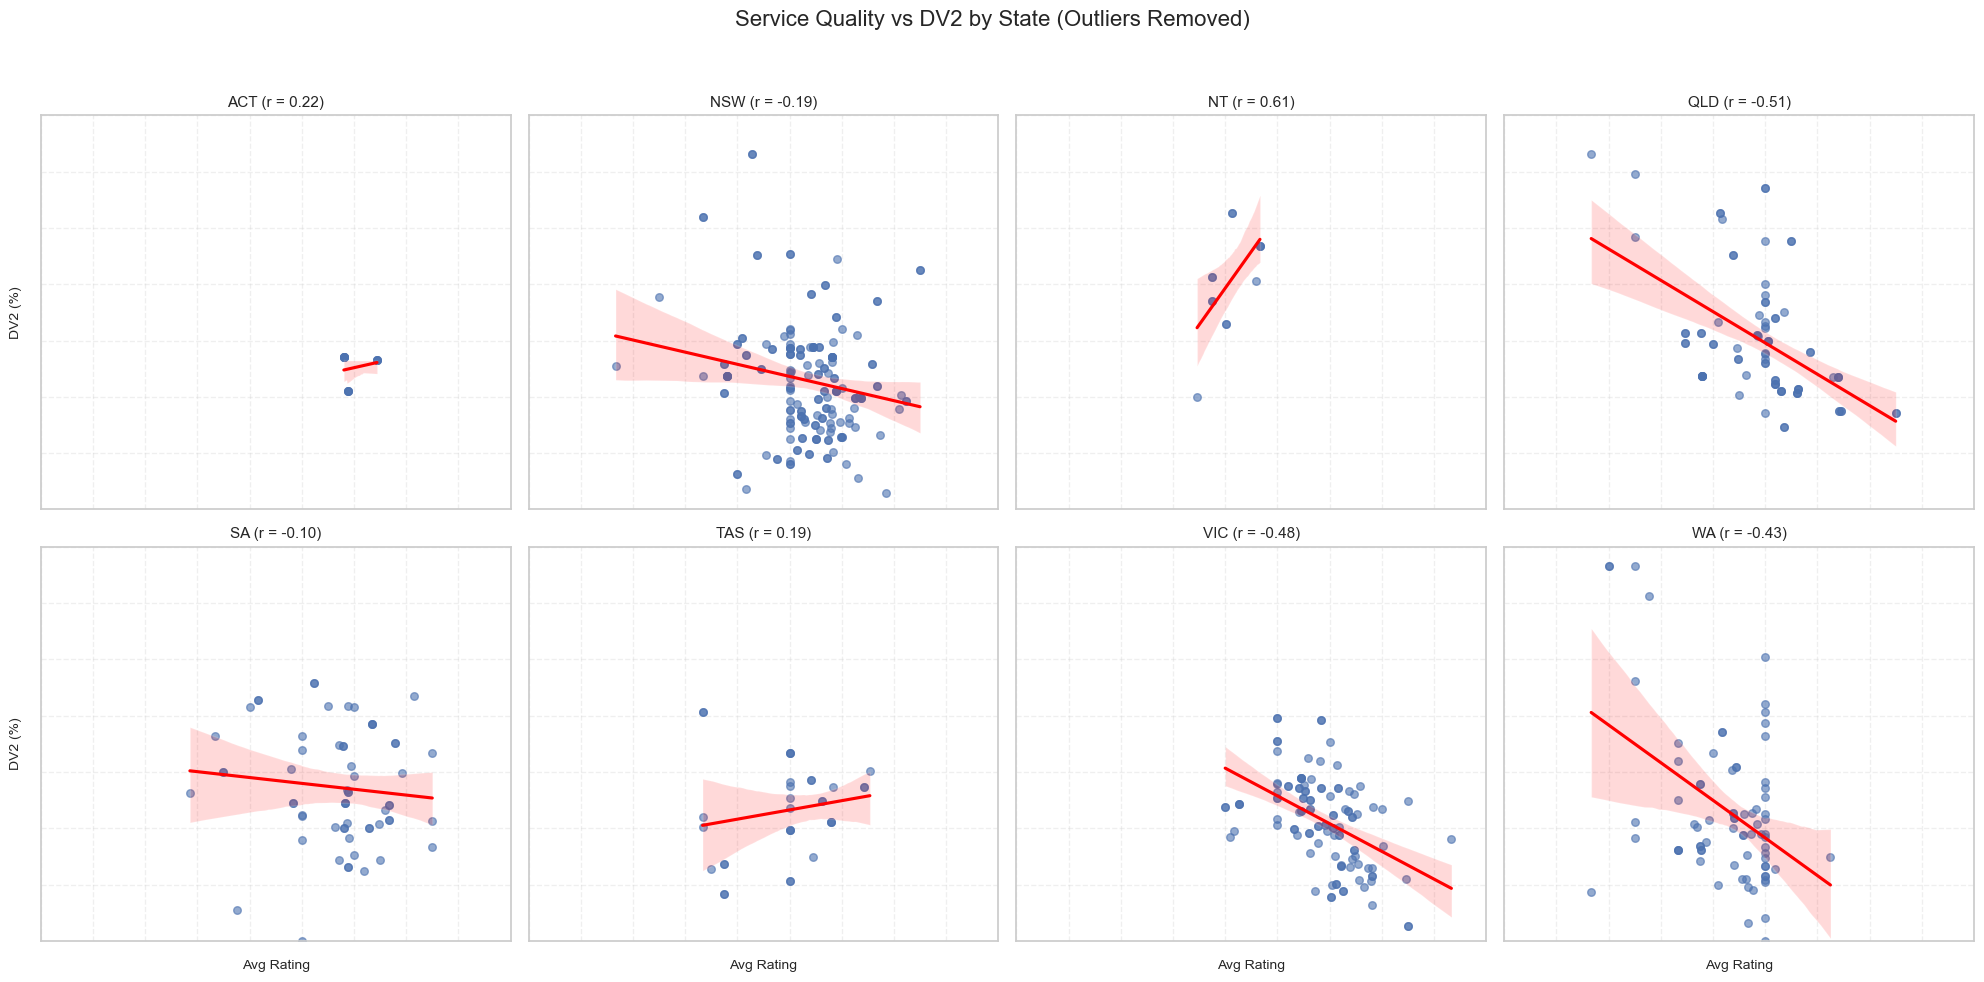

In [46]:
states.sort()

fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
fig.suptitle("Service Quality vs DV2 by State (Outliers Removed)", fontsize=16)

for i, state in enumerate(states):
    row, col = divmod(i, 4)
    ax = axes[row, col]
    
    sub_df = df_lga_filtered[df_lga_filtered["State"] == state]
    corr = sub_df["avg_rating"].corr(sub_df["dv2_percent"])
    
    sns.regplot(
        data=sub_df,
        x="avg_rating", y="dv2_percent",
        scatter_kws={'alpha': 0.6, 's': 30},
        line_kws={'color': 'red'},
        ax=ax
    )
    
    ax.set_title(f"{state} (r = {corr:.2f})", fontsize=11)
    
    if col == 0:
        ax.set_ylabel("DV2 (%)", fontsize=10)
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])

    if row == 1:
        ax.set_xlabel("Avg Rating", fontsize=10)
    else:
        ax.set_xlabel("")
        ax.set_xticklabels([])

    ax.grid(True, linestyle="--", alpha=0.3)
    ax.set_xlim(1.0, 2.8)
    ax.set_ylim(0, 35)

plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()
